In [25]:
cd /opt/ml/code

/opt/ml/code


In [26]:
import random
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score
import cv2

import numpy as np
import pandas as pd

from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

print(f'pytorch version: {torch.__version__}')
print(f'GPU 사용 가능 여부: {torch.cuda.is_available()}')
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1


In [27]:
batch_size = 8
num_epochs = 8
image_size = 256
learning_rate = 0.0001
model_name = 'UNet_256'

In [28]:
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
#torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [29]:
%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/train.json'

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        nr_super_cats += 1
print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


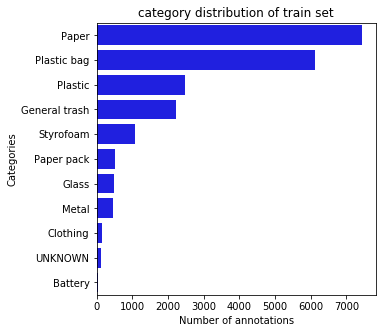

In [30]:
cat_histogram = np.zeros(nr_cats, dtype=int)
for ann_it in anns:
    cat_histogram[ann_it['category_id']] += 1

f, ax = plt.subplots(figsize=(5, 5))
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations':cat_histogram})

plt.title('category distribution of train set')
plot_1 = sns.barplot(x='Number of annotations', y='Categories', data=df.sort_values('Number of annotations', ascending=False), label='Total', color='b')

In [31]:
df = pd.DataFrame({'Categories':['Background']}).append(df, ignore_index=True)

In [32]:
df

,Categories,Number of annotations
0,Background,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


In [33]:
category_names = list(df['Categories'])

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return 'None'

class CustomDataset(Dataset):
    '''COCO'''
    def __init__(self, data_dir, mode='train', transform=None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
    
    def __getitem__(self, index:int):
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]

        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0

        if self.mode in ('train', 'val'):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            masks = np.zeros((image_infos['height'], image_infos['width']))

            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i]) * pixel_value, masks)
            
            if self.transform is not None:
                images, masks = self.transform(image=images, mask=masks).values()
            post_transform = ToTensorV2()
            images, masks = post_transform(image=images, mask=masks).values()

            return images, masks, image_infos
        
        if self.mode == 'test':
            if self.transform is not None:
                images = self.transform(image=images)['image']
            post_transform = ToTensorV2()
            images = post_transform(image=images)['image']

            return images, image_infos

    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [34]:
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(),
    A.OneOf([
        A.MotionBlur(p=1.0),
        A.OpticalDistortion(p=1.0)
    ], p=2/3)
])

val_transform = A.Compose([
    A.Resize(256, 256)
])

test_transform = A.Compose([
    A.Resize(256, 256)
])

train_dataset = CustomDataset(data_dir=train_path, mode='train',transform=train_transform)

val_dataset = CustomDataset(data_dir=val_path, mode='val', transform=val_transform)

test_dataset = CustomDataset(data_dir=test_path, mode='test', transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.74s)
creating index...
index created!
loading annotations into memory...
Done (t=1.47s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


image shape: [3, 256, 256]
mask shape: [256, 256]
Unique values, category of transformed mask:
 {0: 'Background', 2: 'General trash', 3: 'Paper'}


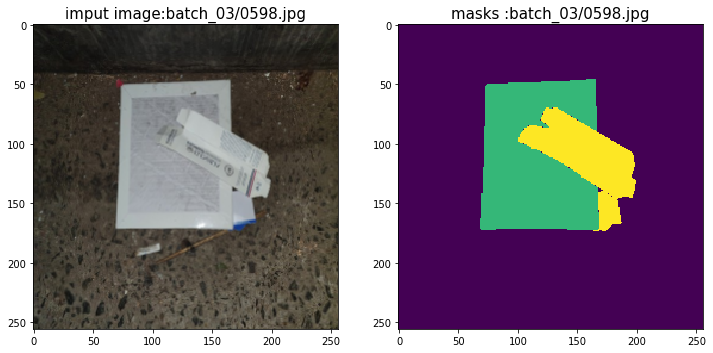

In [35]:
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs[0]
    temp_masks = masks[0]
    break

fig, axes = plt.subplots(1, 2, figsize=(12, 12))
print('image shape:', list(temp_images.shape))
print('mask shape:', list(temp_masks.shape))
print('Unique values, category of transformed mask:\n', {int(i):category_names[int(i)] for i in list(np.unique(temp_masks))})

axes[0].imshow(temp_images.permute([1, 2, 0]))
axes[0].grid(False)
axes[0].set_title('imput image:' + str(image_infos['file_name']), fontsize=15)

axes[1].imshow(temp_masks)
axes[1].grid(False)
axes[1].set_title('masks :' + str(image_infos['file_name']), fontsize=15)

plt.show()

image shape: [3, 256, 256]
mask shape: [256, 256]
Unique values, category of transformed mask:
 {0: 'Background', 6: 'Glass', 7: 'Plastic', 9: 'Plastic bag'}


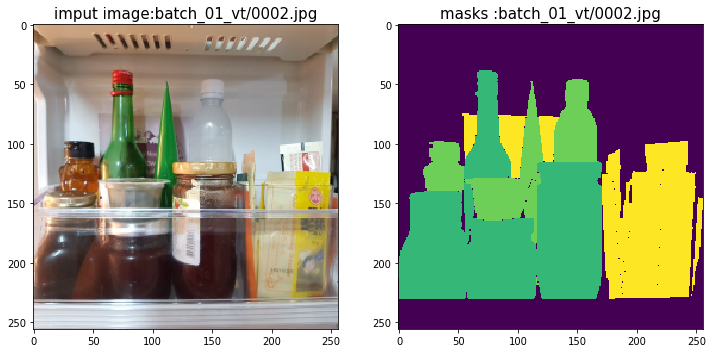

In [36]:
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs[0]
    temp_masks = masks[0]
    break

fig, axes = plt.subplots(1, 2, figsize=(12, 12))
print('image shape:', list(temp_images.shape))
print('mask shape:', list(temp_masks.shape))
print('Unique values, category of transformed mask:\n', {int(i):category_names[int(i)] for i in list(np.unique(temp_masks))})

axes[0].imshow(temp_images.permute([1, 2, 0]))
axes[0].grid(False)
axes[0].set_title('imput image:' + str(image_infos['file_name']), fontsize=15)

axes[1].imshow(temp_masks)
axes[1].grid(False)
axes[1].set_title('masks :' + str(image_infos['file_name']), fontsize=15)

plt.show()

image shape: [3, 256, 256]


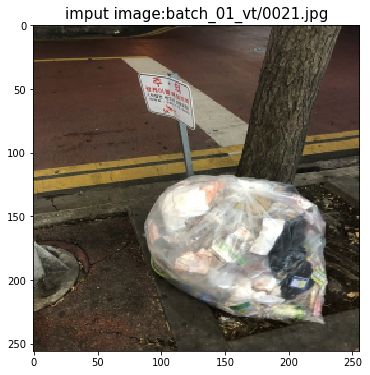

In [37]:
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs[0]
    break

fig, ax = plt.subplots(figsize=(6, 6))
print('image shape:', list(temp_images.shape))

ax.imshow(temp_images.permute([1, 2, 0]))
ax.grid(False)
ax.set_title('imput image:' + str(image_infos['file_name']), fontsize=15)

plt.show()

In [38]:
import torch
import torch.nn as nn
class UNet(nn.Module):
    def __init__(self, num_classes=12):
        super(UNet, self).__init__()
        def CBR(in_channels, out_channels, kernel_size, stride, padding):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        def EncBlock(in_channels, out_channels, kernel_size, stride, padding):
            return nn.Sequential(
                CBR(in_channels, out_channels, kernel_size, stride, padding),
                CBR(out_channels, out_channels, kernel_size, stride, padding)
            )
        def DecBlock(in_channels, out_channels, kernel_size, stride, padding):
            return nn.Sequential(
                CBR(in_channels, in_channels, kernel_size, stride, padding),
                CBR(in_channels, out_channels, kernel_size, stride, padding)
            )
        self.enc1 = EncBlock(3, 64, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = EncBlock(64, 128, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = EncBlock(128, 256, 3, 1, 1)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = EncBlock(256, 512, 3, 1, 1)
        self.pool4 = nn.MaxPool2d(2)
        self.enc5 = EncBlock(512, 1024, 3, 1, 1)
        self.upconv5 = nn.ConvTranspose2d(1024, 512, 2, 2, 0)
        self.dec4 = DecBlock(1024, 512, 3, 1, 1)
        self.upconv4 = nn.ConvTranspose2d(512, 256, 2, 2, 0)
        self.dec3 = DecBlock(512, 256, 3, 1, 1)
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, 2, 0)
        self.dec2 = DecBlock(256, 128, 3, 1, 1)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, 2, 0)
        self.dec1 = DecBlock(128, 64, 3, 1, 1)
        self.score = nn.Conv2d(64, num_classes, 1, 1, 0)

    def forward(self, x):
        def center_crop(in_tensor, out_size):
            x, y = in_tensor.size()[2:4]
            w, h = out_size
            return in_tensor[
                :, :,
                int(x / 2 - w / 2) : int(x / 2 + w / 2),
                int(y / 2 - h / 2) : int(y / 2 + h / 2)
            ]
        x = m1 = self.enc1(x)
        x = self.pool1(x)
        x = m2 = self.enc2(x)
        x = self.pool2(x)
        x = m3 = self.enc3(x)
        x = self.pool3(x)
        x = m4 = self.enc4(x)
        x = self.pool4(x)
        x = self.enc5(x)
        x = self.upconv5(x)
        x = torch.cat([x, center_crop(m4, x.size()[2:4])], dim=1)
        x = self.dec4(x)
        x = self.upconv4(x)
        x = torch.cat([x, center_crop(m3, x.size()[2:4])], dim=1)
        x = self.dec3(x)
        x = self.upconv3(x)
        x = torch.cat([x, center_crop(m2, x.size()[2:4])], dim=1)
        x = self.dec2(x)
        x = self.upconv2(x)
        x = torch.cat([x, center_crop(m1, x.size()[2:4])], dim=1)
        x = self.dec1(x)
        x = self.score(x)

        return x

In [39]:
model = UNet(num_classes=12)
x = torch.randn([1, 3, 256, 256])
print('input shape:', x.shape)
out = model(x).to(device)
print('output shape:', out.shape)
model = model.to(device)

input shape: torch.Size([1, 3, 256, 256])
output shape: torch.Size([1, 12, 256, 256])


In [40]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device, resume=None):
    print('Start training')
    best_loss = 9999999
    epoch_begin = 0

    if resume is not None:
        epoch_begin = resume['epoch_begin'] - 1
        best_loss = resume['best_loss']
        model_name = resume['model_name']
        model_path = f'./saved/{model_name}.pt'
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)

    for epoch in tqdm(range(epoch_begin, num_epochs)):
        model.train()
        for step, (images, masks, _) in tqdm(enumerate(data_loader)):
            images = torch.stack(images).to(device)
            masks = torch.stack(masks).long().to(device)
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (step + 1) % 25 == 0:
                print(f'Epoch[{epoch + 1}/{num_epochs}], Step[{step + 1}/{len(data_loader)}], Loss: {loss.item():.4f}')

        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print(f'Best performance at epoch: {epoch + 1}')
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [41]:
def validation(epoch, model, data_loader, criterion, device):
    print(f'Start validation #{epoch}')
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images).to(device)
            masks = torch.stack(masks).long().to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1

            outputs = torch.argmax(outputs.squeeze(), dim=1)
            outputs = outputs.detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            mIoU = label_accuracy_score(masks, outputs, n_class=12)[2]
            mIoU_list.append(mIoU)
        
        avrg_loss = total_loss / cnt
        print(f'Validation #{epoch} Average Loss: {avrg_loss:.4f}, mIoU: {np.mean(mIoU_list):.4f}')
    return avrg_loss



In [42]:
val_every = 1
saved_dir = './saved'
os.makedirs(saved_dir, exist_ok=True)
def save_model(model, saved_dir, file_name=f'{model_name}.pt'):
    check_point = {'net':model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

In [43]:
criterion= nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-6)

In [44]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start training


  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch[1/8], Step[25/328], Loss: 2.0236
Epoch[1/8], Step[50/328], Loss: 1.8672
Epoch[1/8], Step[75/328], Loss: 1.7066
Epoch[1/8], Step[100/328], Loss: 1.7135
Epoch[1/8], Step[125/328], Loss: 1.5371
Epoch[1/8], Step[150/328], Loss: 1.5334
Epoch[1/8], Step[175/328], Loss: 1.3430
Epoch[1/8], Step[200/328], Loss: 1.5365
Epoch[1/8], Step[225/328], Loss: 1.3212
Epoch[1/8], Step[250/328], Loss: 1.2513
Epoch[1/8], Step[275/328], Loss: 1.1669
Epoch[1/8], Step[300/328], Loss: 1.2230
Epoch[1/8], Step[325/328], Loss: 1.0715
Start validation #1
Validation #1 Average Loss: 1.1747, mIoU: 0.1794
Best performance at epoch: 1
Save model in ./saved


0it [00:00, ?it/s]

Epoch[2/8], Step[25/328], Loss: 1.4179
Epoch[2/8], Step[50/328], Loss: 1.0172
Epoch[2/8], Step[75/328], Loss: 0.9960
Epoch[2/8], Step[100/328], Loss: 0.9960
Epoch[2/8], Step[125/328], Loss: 0.8746
Epoch[2/8], Step[150/328], Loss: 0.8230
Epoch[2/8], Step[175/328], Loss: 1.0270
Epoch[2/8], Step[200/328], Loss: 0.8166
Epoch[2/8], Step[225/328], Loss: 0.7677
Epoch[2/8], Step[250/328], Loss: 0.9078
Epoch[2/8], Step[275/328], Loss: 0.7880
Epoch[2/8], Step[300/328], Loss: 0.7995
Epoch[2/8], Step[325/328], Loss: 0.9116
Start validation #2
Validation #2 Average Loss: 0.8540, mIoU: 0.1803
Best performance at epoch: 2
Save model in ./saved


0it [00:00, ?it/s]

Epoch[3/8], Step[25/328], Loss: 0.7260
Epoch[3/8], Step[50/328], Loss: 0.7349
Epoch[3/8], Step[75/328], Loss: 0.9537
Epoch[3/8], Step[100/328], Loss: 0.8803
Epoch[3/8], Step[125/328], Loss: 0.8912
Epoch[3/8], Step[150/328], Loss: 0.6778
Epoch[3/8], Step[175/328], Loss: 0.7635
Epoch[3/8], Step[200/328], Loss: 0.8003
Epoch[3/8], Step[225/328], Loss: 0.8304
Epoch[3/8], Step[250/328], Loss: 0.9230
Epoch[3/8], Step[275/328], Loss: 0.7334
Epoch[3/8], Step[300/328], Loss: 0.6636
Epoch[3/8], Step[325/328], Loss: 0.7446
Start validation #3
Validation #3 Average Loss: 0.7806, mIoU: 0.1740
Best performance at epoch: 3
Save model in ./saved


0it [00:00, ?it/s]

Epoch[4/8], Step[25/328], Loss: 0.7099
Epoch[4/8], Step[50/328], Loss: 0.7109
Epoch[4/8], Step[75/328], Loss: 0.9001
Epoch[4/8], Step[100/328], Loss: 0.7599
Epoch[4/8], Step[125/328], Loss: 0.6475
Epoch[4/8], Step[150/328], Loss: 0.8931
Epoch[4/8], Step[175/328], Loss: 0.9050
Epoch[4/8], Step[200/328], Loss: 0.7711
Epoch[4/8], Step[225/328], Loss: 0.6460
Epoch[4/8], Step[250/328], Loss: 0.5405
Epoch[4/8], Step[275/328], Loss: 0.5979
Epoch[4/8], Step[300/328], Loss: 0.6094
Epoch[4/8], Step[325/328], Loss: 0.7231
Start validation #4
Validation #4 Average Loss: 0.7163, mIoU: 0.2017
Best performance at epoch: 4
Save model in ./saved


0it [00:00, ?it/s]

Epoch[5/8], Step[25/328], Loss: 0.8287
Epoch[5/8], Step[50/328], Loss: 0.8719
Epoch[5/8], Step[75/328], Loss: 0.5612
Epoch[5/8], Step[100/328], Loss: 0.8675
Epoch[5/8], Step[125/328], Loss: 0.8565
Epoch[5/8], Step[150/328], Loss: 0.6427
Epoch[5/8], Step[175/328], Loss: 0.9807
Epoch[5/8], Step[200/328], Loss: 0.6279
Epoch[5/8], Step[225/328], Loss: 0.7743
Epoch[5/8], Step[250/328], Loss: 0.5320
Epoch[5/8], Step[275/328], Loss: 0.6070
Epoch[5/8], Step[300/328], Loss: 0.8596
Epoch[5/8], Step[325/328], Loss: 0.9859
Start validation #5
Validation #5 Average Loss: 0.6859, mIoU: 0.2005
Best performance at epoch: 5
Save model in ./saved


0it [00:00, ?it/s]

Epoch[6/8], Step[25/328], Loss: 0.5480
Epoch[6/8], Step[50/328], Loss: 0.8460
Epoch[6/8], Step[75/328], Loss: 0.9407
Epoch[6/8], Step[100/328], Loss: 0.5850
Epoch[6/8], Step[125/328], Loss: 0.6807
Epoch[6/8], Step[150/328], Loss: 0.6272
Epoch[6/8], Step[175/328], Loss: 0.6296
Epoch[6/8], Step[200/328], Loss: 0.6362
Epoch[6/8], Step[225/328], Loss: 0.4368
Epoch[6/8], Step[250/328], Loss: 1.0763
Epoch[6/8], Step[275/328], Loss: 0.3817
Epoch[6/8], Step[300/328], Loss: 0.7892
Epoch[6/8], Step[325/328], Loss: 0.5706
Start validation #6
Validation #6 Average Loss: 0.6683, mIoU: 0.2107
Best performance at epoch: 6
Save model in ./saved


0it [00:00, ?it/s]

Epoch[7/8], Step[25/328], Loss: 0.8697
Epoch[7/8], Step[50/328], Loss: 0.8411
Epoch[7/8], Step[75/328], Loss: 0.7576
Epoch[7/8], Step[100/328], Loss: 0.8402
Epoch[7/8], Step[125/328], Loss: 0.5653
Epoch[7/8], Step[150/328], Loss: 0.6325
Epoch[7/8], Step[175/328], Loss: 0.6454
Epoch[7/8], Step[200/328], Loss: 0.8764
Epoch[7/8], Step[225/328], Loss: 0.5269
Epoch[7/8], Step[250/328], Loss: 0.6744
Epoch[7/8], Step[275/328], Loss: 0.4771
Epoch[7/8], Step[300/328], Loss: 0.8181
Epoch[7/8], Step[325/328], Loss: 0.5297
Start validation #7
Validation #7 Average Loss: 0.6547, mIoU: 0.2150
Best performance at epoch: 7
Save model in ./saved


0it [00:00, ?it/s]

Epoch[8/8], Step[25/328], Loss: 0.5632
Epoch[8/8], Step[50/328], Loss: 0.5805
Epoch[8/8], Step[75/328], Loss: 0.8008
Epoch[8/8], Step[100/328], Loss: 0.5411
Epoch[8/8], Step[125/328], Loss: 0.6172
Epoch[8/8], Step[150/328], Loss: 0.4622
Epoch[8/8], Step[175/328], Loss: 0.9503
Epoch[8/8], Step[200/328], Loss: 0.5280
Epoch[8/8], Step[225/328], Loss: 0.7092
Epoch[8/8], Step[250/328], Loss: 0.8867
Epoch[8/8], Step[275/328], Loss: 0.7137
Epoch[8/8], Step[300/328], Loss: 0.5634
Epoch[8/8], Step[325/328], Loss: 0.5213
Start validation #8
Validation #8 Average Loss: 0.6104, mIoU: 0.2311
Best performance at epoch: 8
Save model in ./saved


In [45]:
model_path = f'./saved/{model_name}.pt'
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

Shape of Original Image: [3, 256, 256]
Shape of Predicted: [256, 256]
Unique values, category of transformed mask
 {0: 'Background', 2: 'General trash', 3: 'Paper', 9: 'Plastic bag'}


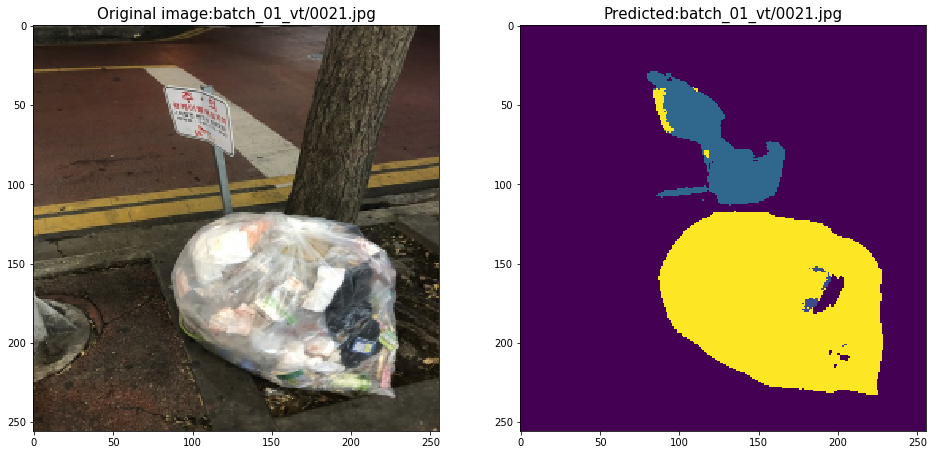

In [46]:
for imgs, image_infos in test_loader:
    model.eval()
    outs = model(torch.stack(imgs).to(device))
    outs = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    break

imgs = imgs[0]
image_infos = image_infos[0]
outs = outs[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 16))
print('Shape of Original Image:', list(imgs.shape))
print('Shape of Predicted:', list(outs.shape))
print('Unique values, category of transformed mask\n', {int(i):category_names[int(i)] for i in list(np.unique(outs))})

axes[0].imshow(imgs.permute([1,2,0]))
axes[0].grid(False)
axes[0].set_title('Original image:' + str(image_infos['file_name']), fontsize=15)

axes[1].imshow(outs)
axes[1].grid(False)
axes[1].set_title('Predicted:' + str(image_infos['file_name']), fontsize=15)

plt.show()

In [47]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction')
    model.eval()

    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in tqdm(enumerate(data_loader)):
            outs = model(torch.stack(imgs).to(device))
            outs = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()

            masks = []
            for img, mask in zip(np.stack(imgs), outs):
                img, mask = transform(image=img, mask=mask).values()
                masks.append(mask)
            outs = np.array(masks)
            outs = outs.reshape([outs.shape[0], size * size]).astype(int)
            preds_array = np.vstack((preds_array, outs))

            file_name_list.append([i['file_name'] for i in image_infos])
    print('End prediction.')
    file_names = [y for x in file_name_list for y in x]
    return file_names, preds_array

In [48]:
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)
file_names, preds = test(model, test_loader, device)

for file_name, string in zip(file_names, preds):
    submission = submission.append({'image_id':file_name, 'PredictionString':' '.join(str(e) for e in string.tolist())}, ignore_index=True)

submission.to_csv(f'./submission/{model_name}.csv', index=False)

Start prediction


0it [00:00, ?it/s]

End prediction.
